**PHASE I: Course Review.**

In this project, we will explore and analyze data from NYC Taxi and Limousine Commission (TLC) in December 2018. We then build a classification model to determine whether a trip will be tipped. By interpreting the feature importances, we will understand what types of trips are more likely to be tipped. 

Please download data from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).
Click **2018 --> December --> Green (CSV)**


The green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data dictionary can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) # this will show all the columns in dataframe

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6]

%matplotlib inline 

from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

# skip all warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Preprocessing Data

Let's take a quick look at the dataset. First we load Green Taxi trip data on December, 2018. By explaining features one by one, we could understand the domain knowledge better. Besides, we also take a look at the shape of data as well as missing values.

In [2]:
# pandas load data
trips = pd.read_csv('./green_tripdata_2018-12.csv')

In [3]:
# shape of data
print (trips.shape)

# read every feature in details
print (trips.columns.tolist())

(685373, 19)
['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type']


* VendorID: LPEP provider that provided the data record (1 = Creative Mobile Technologies, LLC; 2=VeriFone Inc.)
* lpep_pickup_datetime: The time when meter was engaged
* lpep_dropoff_datetime: The time when meter was disengaged
* store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server
* RatecodeID: The final rate code in effect at the end of the trip.
* PULocationID: TLC taxi zone for pickup
* DOLocationID: TLC taxi zone for dropoff
* passenger_count: The number of passengers in the vehicle. Recorded by driver
* trip_distance: trip distance in miles
* fare_amount: The time-and-distance fare calculated by the meter
* extra: the 0.50 and 1 rush hour, and overnight charges
* mta_tax: 0.50 MTA tax that is automatically triggered based on the metered rate in use
* tip_amount: This field is automatically populated for credit card tips. **Cash tips are not included**
* tolls_amount: Total amount of all tolls paid in trip
* ehail_fee: NULL
* improvement_surcharge: 0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015
* total_amount: The total amount charged to passengers. **Does not include cash tips**
* payment_type: how the passenger paid for the trip
* trip_type: A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver

From the above description, we find an interesting thing that might affect the prediction of tips. We do not have cash tips information in the dataset. To make it closer to the Uber situation, we filter dataset with `payment_type = 1`, which is credit card. Then we report data shape and missing value.

In [4]:
# choose payment type as credit card
trips_cc = trips[trips['payment_type']==1]

# data shape again
print (trips_cc.shape)

# missing value
trips_cc.isnull().sum()

(406690, 19)


VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
passenger_count               0
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                406690
improvement_surcharge         0
total_amount                  0
payment_type                  0
trip_type                     0
dtype: int64

Nearly 40% of the data are removed. Even thought, the dataset is large enough to make prediction.

To see the missing value, data is actually pretty clean, with no missing value except feature 'ehail_fee', which contains all missing value and should be removed. The dataset is clean because we only choose "credit card" payment type. Some other missing values may occur at other payment type.

Besides, `VendorID` is the id-like variable and should also be removed. Since we already choose credit card, `payment_type` can be removed.

In [5]:
# data cleaning

# remove ehail_fee, VendorID and payment_type
trips_cc.drop(['ehail_fee', 'VendorID', 'payment_type'], axis=1, inplace=True)

# Exploratory Data Analysis

In this section, we run Exploratory Data Analysis on our dataset. In EDA, we should find some correlations between features and target variable, which is not defined in our dataset. Therefore, we need to derive a new variable `is_tipped`, to be our response variable. 

You should be able to implement this from `tip_amount`. That is, set `is_tipped` to 0, if `tip_amount` is 0. Else, set it to 1. So, let's first explore feature `tip_amount`.

## Tip Amount

In [6]:
trips_cc['tip_amount'].describe()

count    406690.000000
mean          1.591567
std           2.280100
min           0.000000
25%           0.000000
50%           1.170000
75%           2.340000
max         300.000000
Name: tip_amount, dtype: float64

Negative values are found, which makes no sense! There are several things you can do about it.

* Find out samples with negative tip amount
* Compute number of those samples
* Remove them or impute with 0

There is only one sample with tip amount less than 0. We can definitely remove it. By looking at this sample, I might say that this negative `fare_amount` and `tip_amount` are due to the order cancellation from driver. But additional information is needed, if we want to know details. 

In [7]:
# number of samples with tip amount less than 0
print (sum(trips_cc['tip_amount']<0))

# sample
trips_cc[trips_cc['tip_amount']<0]

0


,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type


In [8]:
# remove it
trips_cc = trips_cc[trips_cc['tip_amount']>=0]

## Target: is_tipped

Now we can create a new feature `is_tipped` from `tip_amount`. Then we explore the distribution of `is_tipped`.

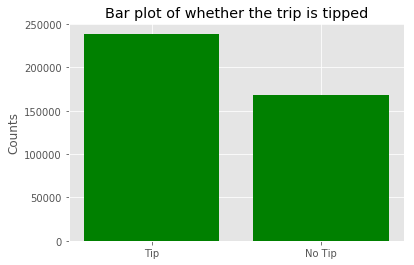

In [9]:
# create a new feature, named is_tipped
trips_cc['is_tipped'] = trips_cc['tip_amount'].apply(lambda x: 0 if x == 0 else 1)

# Bar plot
x_pos = ['Tip','No Tip']
x = trips_cc['is_tipped'].value_counts()

plt.bar(x_pos, x, color='green')
plt.ylabel("Counts")
plt.title("Bar plot of whether the trip is tipped")
plt.show()

The distribution of data is balanced. At least, we do not worry about the imbalance problem in classification model.

## Total Amount

Let's also explore a continuous variable. If you see the distribution of `total_amount`, it also shows negative values. However, Green Taxi has a minimum total amount of 2.5. So, we believe the records with total amount less than 2.5 are considered outliers. There are 246 outliers in total. As our total sample size is 417076, we could remove those outliers.

In [10]:
# total amount
print (trips_cc['total_amount'].describe())
print()

# number of samples with total amount less than 2.5
print (sum(trips_cc['total_amount']<=2.5))

count    406690.000000
mean         19.681983
std          14.796286
min         -26.240000
25%           9.960000
50%          14.800000
75%          23.800000
max         495.000000
Name: total_amount, dtype: float64

343


In [11]:
# remove outliers
trips_cc = trips_cc[trips_cc['total_amount']>2.5]

Histogram plot is to describe the distribution of a continuous variable. It is heavily right skewness. So it might be clear if taking log transformation.

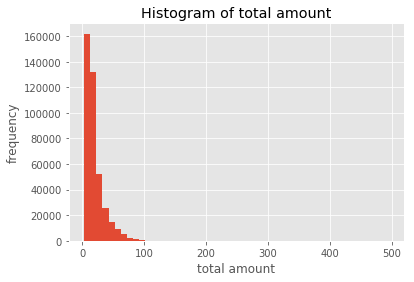

In [12]:
# the distribution of total amount
trips_cc['total_amount'].hist(bins=50)
plt.xlabel("total amount")
plt.ylabel("frequency")
plt.title("Histogram of total amount")
plt.show()

## Correlations

Previously we explore a single variable. In this section, we will find the relationship between two features. Actually, we are interested in relation between each feature and the target. Let's see the numerical variables first. 

In [13]:
trips_cc.columns.tolist()

['lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'trip_type',
 'is_tipped']

In [14]:
# filter numerical features
trips_numerical = trips_cc.select_dtypes(include = 'float64').corr()

# print correlation coefs  between each feature and target
print(trips_numerical['tip_amount'].sort_values(ascending = False))

tip_amount               1.000000
total_amount             0.254958
improvement_surcharge    0.185363
extra                    0.110256
fare_amount              0.098363
trip_distance            0.077634
tolls_amount             0.044187
mta_tax                 -0.065341
trip_type               -0.185170
Name: tip_amount, dtype: float64


We already know that `is_tipped` is derived from `tip_amount`, which then should be removed from dataset. But we want to explore some other features that might have high correlation with `tip_amount`. 

* As we know, `fare amount` is recorded from the machine in Taxi, which is not the cause of tips. It should be included.
* `total amount` should be the total money a passenger pays for this trip. This feature contains the information of tips! If we want to predict tips, this feature should not appear in dataset. Otherwise, we are using y to predict y.

Still, we might wonder if tip amount has a high correlation with total amount minus fare amount.

As shown below, there is a high correlation between tip amount and total amount minus fare amount, which proves our previous analysis.

In [15]:
# coefficient
np.corrcoef(trips_numerical['tip_amount'], 
            trips_numerical['total_amount'] - trips_numerical['fare_amount'])

array([[1.        , 0.86598544],
       [0.86598544, 1.        ]])

# Feature Engineering

In this section, we prepare data for classification model. First we create time-related new features, using pickup and dropoff time. Second, we analyze other features such as mta_tax, improvement surcharge and passenger count to get some insights. Third, we remove all irrelevant variables.

## Create New Features

The new features we create includes day of month, weekday, hour from pickup datetime. We can also generate trip duration and trip speed, which are easy to get from original features. 

In [16]:
# TIME-RELATED

# convert lpep pickup datetime to standard datetime format
trips_cc['pickup_datetime'] = trips_cc['lpep_pickup_datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
# extract day of month
trips_cc['monthday'] = trips_cc['pickup_datetime'].apply(lambda x: x.day)
# get weekday
trips_cc['weekday'] = trips_cc['pickup_datetime'].apply(lambda x: x.weekday() + 1)
# get hour of day
trips_cc['hour'] = trips_cc['pickup_datetime'].apply(lambda x: x.hour)

In [17]:
# TRIP DURATION/SPEED

# derive Trip duration
trips_cc['dropoff_datetime'] = trips_cc['lpep_dropoff_datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
trips_cc['trip_duration'] = (trips_cc['dropoff_datetime'] - trips_cc['pickup_datetime']) / np.timedelta64(1, 'm')

# remove duration less than 0
trips_cc = trips_cc[trips_cc['trip_duration'] > 0]

# derive average trip speed with miles per hour
trips_cc['trip_speed'] = trips_cc['trip_distance'] / (trips_cc['trip_duration'] / 60.0)

# remove speed greater than 80
trips_cc = trips_cc[trips_cc['trip_speed'] <= 80]

## Other Features

By analyzing value counts of `mta_tax` and `improvement_surcharge` below, we see the imbalance of the values. Thus these two features may not contribute much to the predictive models. But number of features here are small, so we still keep them in the dataset.

For `passenger_count`, we remove those 0-passenger samples. Besides, we set 6,7,8,9 as one level. 

In [18]:
# mta_tax
print (trips_cc['mta_tax'].value_counts())
print()
# improvement_surcharge
print (trips_cc['improvement_surcharge'].value_counts())
print()
# passenger_count
print (trips_cc['passenger_count'].value_counts())

# remove 0 passenger
trips_cc = trips_cc[trips_cc['passenger_count'] != 0]

# merge 7/8/9 to 6 
trips_cc['passenger_count'] = trips_cc['passenger_count'].apply(lambda x: 6 if x >= 6 else x)

0.5    401781
0.0      4087
Name: mta_tax, dtype: int64

0.3    367616
0.0     38252
Name: improvement_surcharge, dtype: int64

1    351072
2     27582
5     13576
6      6232
3      5017
4      1630
0       745
8         6
7         5
9         3
Name: passenger_count, dtype: int64


## Remove Irrelevant Variables

Datetime-related features are irrelevant. It makes no sense to add those variables to model. In addition, we have already extract useful information from them. Thus we can remove them.

Store_and_fwd_flag feature indicates whether the trip record was held in vehicle memory before sending to the vendor. This might differ because the vehicle did not have a connection to the server, which has no relationship with tip. We can also remove it.

At last, tip amount and total amount should be removed, since it is response-related variable!

In [19]:
trips_cc.drop(['lpep_pickup_datetime',
               'lpep_dropoff_datetime',
               'pickup_datetime',
               'dropoff_datetime',
               'store_and_fwd_flag',
               'tip_amount', 'total_amount'],axis=1, inplace=True)

## Discretization 

In this section, we will perform discretization of continuous features. Even though discretization may bring error, it decreases the effect of outliers and computational efforts.

* The pickup and dropoff location ID can be clustered into several district, based on the [taxi zone maps](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 
* `trip_duration`, `trip_speed`, `trip_distance` and `fare_amount` are highly right sknewed. Thus, we might want to take the log transformation, and bin with equal frequency.
* `mta_tax`, `improvement_surcharge` and `tolls_amount` both have a large number of 0. So we'd better convert them to binary variables (0/1).
* We label encoder `extra`.


### Locations

In [ ]:
from IPython.display import Image, display

listOfImageNames = ['./test/taxi_zone_map_bronx.jpg', 
                    './test/taxi_zone_map_brooklyn.jpg',
                    './test/taxi_zone_map_manhattan.jpg', 
                    './test/taxi_zone_map_queens.jpg',
                    './test/taxi_zone_map_staten_island.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName,width=600, height=600))

In [28]:
taxi_zone = pd.read_csv("./taxi+_zone_lookup.csv")

In [29]:
# join pickup
tmp = trips_cc.merge(taxi_zone[['LocationID', 'Borough']], 
                     left_on="PULocationID", right_on="LocationID", how="left")
# join dropoff
trips_merged = tmp.merge(taxi_zone[['LocationID', 'Borough']], 
                        left_on="DOLocationID", right_on="LocationID", how="left")
# remove redundant features
trips_merged.drop(columns=["PULocationID", "DOLocationID", "LocationID_x", "LocationID_y"], axis=1, inplace=True)
# rename location features
trips_merged.rename(columns={"Borough_x":"PULocation", "Borough_y":"DOLocation"}, inplace=True)
# create a feature of whether pickup location is the same as drop off
# 1: different, 0: same
trips_merged["PU_DO"] = (trips_merged["PULocation"]!=trips_merged["DOLocation"]).astype(int)

# label encoder pickup and dropoff location
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trips_merged['PULocation'])
trips_merged['PULocation'] = le.transform(trips_merged['PULocation'])
trips_merged['DOLocation'] = le.transform(trips_merged['DOLocation'])

### Binning (NOT APPLIED)

In [ ]:
from pandas import qcut

# take the log transformation
log_features = ['trip_duration', 'trip_speed', 'trip_distance', 'fare_amount']
for f in log_features:
    trips_merged[f] = qcut(np.log(trips_merged[f]+0.01), q=6, labels=range(6))

### Binary (NOT APPLIED)

In [ ]:
binary_features = ['mta_tax', 'improvement_surcharge', 'tolls_amount']

for f in binary_features:
    trips_merged[f] = (trips_merged[f]!=0).astype(int)

### LabelEncoder  (NOT APPLIED)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(trips_merged['extra'])
trips_merged['extra'] = le.transform(trips_merged['extra'])

In [ ]:
trips_merged.head()

# Feature Selection (Optional)

When there are too many features and it is impossible to handle them manually, one way to solve the problem is to perform feature selection. Even though some models has feature selection functionality (LASSO), which is called embeded feature seletion, here we introduce filter method using two measure, Chi-square and F-score. 

Please note that, in this dataset, the number of features is not large. Thus, feature selection might not increase the model performance, especially for some complicated models such as Random Forest and Boosting. 

In [30]:
from sklearn.feature_selection import chi2, f_classif

def selectFeatures(method, X, y, features):
    
    # method check
    if method not in ["chi2", "f"]:
        raise Exception("Only Chi2 and f score are supported.")
    if method == "chi2":
        score, _ = chi2(X, y)
    elif method == "f":
        score, _ = f_classif(X, y)
    score = np.nan_to_num(score)
    return sorted(zip(*(features, score)), key=lambda x: x[1], reverse=True)

In [31]:
# get X and y
features = [x for x in trips_merged.columns if x not in ['is_tipped']]
X = trips_merged[features].values
y = trips_merged['is_tipped'].values

# feature selection 
chi2 = selectFeatures('chi2', X, y, features)
f = selectFeatures('f', X, y, features)

# show results
chi2_df = pd.DataFrame(chi2, columns=['feature','chi2'])
f_df = pd.DataFrame(f, columns=['feature','f_score'])
merged_df = chi2_df.merge(f_df,on='feature',how='inner')

print(merged_df)

                  feature           chi2       f_score
0             fare_amount  546999.849412  55956.568044
1           trip_duration  391785.566601   1202.379663
2           trip_distance  225853.887075  50110.806457
3            tolls_amount   65950.372953  10923.099761
4              RatecodeID   49349.367416  56350.370715
5              PULocation   20031.295068  23779.274228
6              DOLocation   18108.902834  23754.762603
7                    hour    9758.955785   4185.586518
8              trip_speed    8625.169828   2885.269917
9                   extra    7955.595962  15628.255095
10                  PU_DO    7900.396783  10218.018853
11              trip_type    3870.236371  56597.275144
12                weekday    1598.778826   1612.201030
13  improvement_surcharge    1404.786026  56627.051304
14               monthday    1237.027890    250.193554
15                mta_tax       0.131200     26.458643


In [32]:
trips_merged.drop(["passenger_count"], axis=1, inplace=True)

For both of the feature selection methods, variables `passenger_count` has relatively low scores and I just remove them. 

Now we are ready for the modeling !

In [36]:
trips_merged.head()

,RatecodeID,trip_distance,fare_amount,extra,tolls_amount,improvement_surcharge,trip_type,is_tipped,monthday,weekday,hour,trip_duration,trip_speed,PULocation,DOLocation,PU_DO
0,1,1.55,8.0,0.5,0.0,0.3,1.0,1,1,6,0,9.200000,10.108696,1,1,0
1,1,1.32,7.0,0.5,0.0,0.3,1.0,0,1,6,0,7.500000,10.560000,3,3,0
2,1,0.68,4.0,0.5,0.0,0.3,1.0,1,1,6,0,2.016667,20.231405,3,3,0
3,1,0.97,6.0,0.5,0.0,0.3,1.0,1,1,6,0,5.733333,10.151163,3,3,0
4,1,2.69,12.5,0.5,0.0,0.3,1.0,1,1,6,0,16.300000,9.901840,1,1,0


# Predictive Modeling

We are going to train a classification model, to determine if a trip will be tipped or not. Let's follow the instructions below. 

* Get X and y from `trips_cc` dataframe.
* Split data into train/test, 80000 test.
* Model selection. Use training set to run cross validation on all classification models and choose top two.
* Fine tune three models using `RandomizedSearchCV`.
* Show feature importance.
* Ensemble three models using majority vote.
* Stacking three models using `StackingCVClassifier`.
* Compare all five models on test set.

## Train Test Split

In [33]:
# get X and y

y = trips_merged['is_tipped'].values
X = trips_merged.drop(['is_tipped'], axis=1).values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.shape

(324098, 15)

## Model Selection

Let's roughly train Logistic Regression, Decision Tree, Random Forest, XGBoost, ..., using 3-fold cross validation. 

In [35]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
import time

# 9 candidate models
models = [LogisticRegression(), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          AdaBoostClassifier(),
          XGBClassifier(),
          KNeighborsClassifier(),
          ExtraTreesClassifier()]

labels = ['lr','dt','rf','ada','xgb','knn','et']

print('5-fold cross validation:\n')
# train models
for model, label in zip(models,labels):
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.7639 (+/- 0.0010) [lr]
Accuracy: 0.7167 (+/- 0.0009) [dt]
Accuracy: 0.7788 (+/- 0.0006) [rf]
Accuracy: 0.7854 (+/- 0.0009) [ada]
Accuracy: 0.7948 (+/- 0.0013) [xgb]
Accuracy: 0.7590 (+/- 0.0005) [knn]
Accuracy: 0.7668 (+/- 0.0003) [et]


From the results above, we would like to choose Logistic Regression, Random Forest, AdaBoost, XGBoost, KNN and Extra Trees. Then, we will be using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to tune hyperparameters. 

## Tune Hyperparameters

To tune hyperparameters, for each model we need to set up several hyperparameters as well as their possible values. For example, in Random Forest, `n_estimators` is the number of trees. Possible values are `np.arange(50,300,30)`. There are also `max_depth` and `min_samples_split`. 

After we prepare for the hyperparameters, `GridSearchCV` will go through all possible combinations. During hyperparameter tuning, we also store the best estimator, best parameters, best accuracy and running time to make comparison. 

**Note:** It might be running 35 mins for the current setttings.

In [41]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
lr_params = {
    'C': np.linspace(0.1,1,5,endpoint=True),
    'penalty': ['l2']
}

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': np.arange(2,5),
    'min_samples_leaf':[1,2]
}

# AdaBoost hyperparameters
ada_params = {
    'n_estimators':[300],
    'learning_rate':[0.1,0.4,0.7]
}

# XGBoost hyperparameters
xgb_params = {
    'n_estimators':[300],
    'learning_rate':np.arange(0.1,1,0.3),
    'max_depth':[3],
    'min_child_weight':[2],
    'gamma':[0.2],
    'subsample':[0.8]
}

# K Nearest Neighbor Classifier
knn_params = {
    'n_neighbors':[5],
    'leaf_size':[2,4],
    'algorithm':['auto','kd_tree'] 
}

# Extra Trees Parameters
et_params = {
    'n_estimators':[300],
    'max_depth': [None],
    'min_samples_split': np.arange(2,5),
    'min_samples_leaf':[1,2]
}

# models
lr_clf = LogisticRegression
rf_clf = RandomForestClassifier
ada_clf = AdaBoostClassifier
xgb_clf = XGBClassifier
knn_clf = KNeighborsClassifier
et_clf = ExtraTreesClassifier

# pairs list
# pairs list
clf_params = [(lr_clf,lr_params),
              (rf_clf,rf_params),
              (ada_clf,ada_params),
              (xgb_clf,xgb_params),
              (knn_clf,knn_params),
              (et_clf,et_params)]

In [42]:
# hyperparameter tuning
tune_results = {}

for clf, params in clf_params:
    
    start = time.time()
    tune = GridSearchCV(clf(),params,scoring="accuracy",cv=3,verbose=True,n_jobs=-1)
    tune.fit(X_train, y_train)
    best_estimator = tune.best_estimator_
    best_params = tune.best_params_
    best_score = tune.best_score_
    tune_results[clf] = (best_estimator, best_params, best_score, (time.time()-start)/60)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   15.4s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.6s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  9.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  9.4min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.5min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.8min remaining:   53.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.8min finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  1.1min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  9.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.8min finished


In [44]:
# Show results of tuning hyperparameters
tune_results

{sklearn.linear_model.logistic.LogisticRegression: (LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False),
  {'C': 0.1, 'penalty': 'l2'},
  0.7639849675098273,
  0.39316043456395466),
 sklearn.ensemble.forest.RandomForestClassifier: (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  {'max_depth': None,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 300},
  0.80475967

Each model improves significantly after hyperparameter tuning, compared with the training by default settings. The performance for these three models can be improved further, if we put more possible parameter settings, which will also increase the running time.

## Feature Importance

Another advantage of choosing those three models is that all of them has method `feature_importances_`. Now let's draw three feature importance curves together in a single figure. 

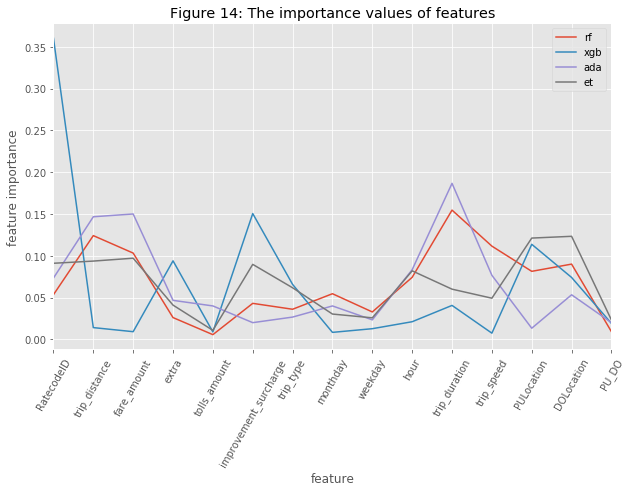

In [47]:
predictors = [x for x in trips_merged.columns if x != 'is_tipped']
# show feature importances
feature_importance = pd.DataFrame(predictors, columns=['feature'])
feature_importance['rf'] = tune_results[rf_clf][0].feature_importances_
feature_importance['xgb'] = tune_results[xgb_clf][0].feature_importances_
feature_importance['ada'] = tune_results[ada_clf][0].feature_importances_
feature_importance['et'] = tune_results[et_clf][0].feature_importances_
feature_importance.plot(x='feature',y=['rf','xgb','ada','et'],xticks=range(len(predictors)),rot=60,figsize=(10,6))
plt.ylabel('feature importance')
plt.title("Figure 14: The importance values of features")
plt.show()

## Stacking

In this section, we are going to implement stacking from scratch. Each individual classifier has the best parameters given by section 5.3. The meta classifier is Logistic Regression with default parameters. 

First, we get prediction values from these models, using cross validation. Note that, at the same time you should convert your test set into the format you need. 

The function 
```Python
def get_oof()
```
helps you implement the cross validation.

In [50]:
from sklearn.model_selection import KFold
import scipy

def get_oof(clf, x_train, y_train, x_test):
    
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    kf = KFold(n_splits= 3, random_state=42)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((3, ntest))
    i = 0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        i += 1
    
    oof_test[:] = scipy.stats.mode(oof_test_skf, axis=0)[0]
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Then you might use the optimal parameters obtained in section 5.3 to train your models and get stacked dataseet.

In [51]:
stack_train = []
stack_test = []

for clf, _ in clf_params:
    tmp = clf(**tune_results[clf][1])
    oof_train, oof_test = get_oof(tmp, X_train, y_train, X_test)
    stack_train.append(oof_train)
    stack_test.append(oof_test)
    
X_train_stacked = np.concatenate(stack_train, axis=1)
X_test_stacked = np.concatenate(stack_test, axis=1)

# meta classifier
metas = {}
for clf, _ in clf_params:
    metas[clf] = clf().fit(X_train_stacked, y_train)

## Ensemble

Let's ensemble all the model results together, including individuals and stacking, from scratch. 

In [55]:
ensemble_res = []

for clf, _ in clf_params:
    ensemble_res.append(metas[clf].predict(X_test_stacked))
    ensemble_res.append(tune_results[clf][0].predict(X_test))

In [57]:
import scipy

# make prediction
ensemble_arr = np.array(ensemble_res)
ensemble_pred = scipy.stats.mode(ensemble_arr, axis=0)[0][0,:]

In [58]:
ensemble_pred

array([1, 0, 0, ..., 1, 0, 0])

## On Test Set

Now, we have six individual models, six stacking models and one ensemble model. Let's apply all models on test set, and compute accuracy scores.

In [60]:
# individuals,
model_labels = ['lr','rf','ada','xgb','knn','et']
all_clfs = [x[0] for x in clf_params]

for clf, label in zip(all_clfs, model_labels):
    print ("Accuracy: %0.4f [%s]" %(tune_results[clf][0].score(X_test,y_test), label))
    
# stacking
stack_labels = ['lr_stack','rf_stack','ada_stack','xgb_stack','knn_stack','et_stack']

for clf, label in zip(all_clfs, stack_labels):
    print ("Accuracy: %0.4f [%s]" %(metas[clf].score(X_test_stacked,y_test), label))

# ensemble
from sklearn.metrics import accuracy_score
print ("Accuracy: %0.4f [%s]" %(accuracy_score(y_test, ensemble_pred), "ensemble"))

Accuracy: 0.7641 [lr]
Accuracy: 0.8053 [rf]
Accuracy: 0.7871 [ada]
Accuracy: 0.8078 [xgb]
Accuracy: 0.7626 [knn]
Accuracy: 0.8039 [et]
Accuracy: 0.8054 [lr_stack]
Accuracy: 0.8071 [rf_stack]
Accuracy: 0.8054 [ada_stack]
Accuracy: 0.8066 [xgb_stack]
Accuracy: 0.7987 [knn_stack]
Accuracy: 0.8069 [et_stack]
Accuracy: 0.8056 [ensemble]


# Conclusion

We use 6 classification models to fit green taxi data, to classify whether a trip will be tipped or not. During model selection, Random Forest, AdaBoost and XGBoost outperformed. This is reasonable, since they are all complicated models. Logistic Regression and Decision Tree are too simple, and somehow underfitting the data. 

We fine tuned these models and get the following results.

|model|best params|best accuracy|run time(mins)|
|-----|-----------|--------|--------|
|Logistic Regression|{'C': 0.1, 'penalty': 'l2'}|0.7640| 0.39|
|Random Forest|{'min_samples_leaf': 2,'min_samples_split': 2,'n_estimators': 300}|0.8048| 11.7|
|XGBoost|{'learning_rate': 0.7,'min_child_weight': 2,'n_estimators': 300}|0.8057|2.99|
|AdaBoost|{'learning_rate': 0.7, 'n_estimators': 300}|0.7880|3.67|
|KNN|{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 5}|0.7590|1.15|
|Extra Trees|{'min_samples_leaf': 2,'min_samples_split': 4,'n_estimators': 300}|0.8045|12.0|

XGBoost gets the best performance among these models. 

For feature importances, pickup/dropoff location and trip duration are more important than other features. The results make sense. First of all, it is more likely that a long trip will be tipped than a short trip. Second, people  in a certain fixed area may be more likely to give tips, for example, pick up location is airport.

In addition, we use stacking and ensemble methods to combine models together. The predictive performances on test set are as follows.

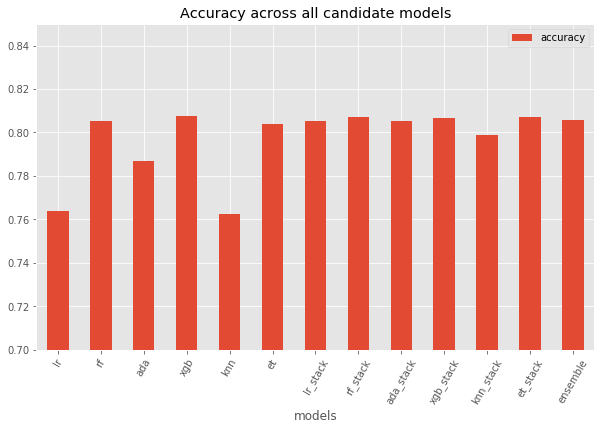

In [70]:
final_res = pd.DataFrame()
final_res['models'] = ['lr','rf','ada','xgb','knn','et' ,
                       'lr_stack' ,'rf_stack','ada_stack','xgb_stack','knn_stack','et_stack' ,
                       'ensemble']
final_res['accuracy'] = [0.7641,0.8053,0.7871,0.8078,0.7626,0.8039,
                         0.8054,0.8071,0.8054,0.8066,0.7987,0.8069,0.8056]
final_res.plot.bar(x='models',y='accuracy',rot=60,figsize=(10,6))
plt.ylim(0.7,0.85)
plt.title("Accuracy across all candidate models")
plt.show()

|model|accuracy|
|-----|-----------|
|lr        | 0.7641 |
|rf        | 0.8053 |
|ada       | 0.7871 |
|xgb       | 0.8078 |
|knn       | 0.7626 |
|et        | 0.8039 |
|lr_stack  | 0.8054 |
|rf_stack  | 0.8071 |
|ada_stack | 0.8054 |
|xgb_stack | 0.8066 |
|knn_stack | 0.7987 |
|et_stack  | 0.8069 |
|ensemble  | 0.8056 |

The result shows that Stacking method is promising. 

In some Data Challenge projects or Kaggle, a good result heavily relies on the condition of your dataset. Sometimes a simple model such as Logistic Regression outperforms other complicated models. Sometimes stacking and ensemble do not make much difference. Model tuning is also very dependent on experience. There is no right or wrong solution. All you have to do is practice more. 

